# Time Series Basic Guide

#### By Carlos Santillán

#### December 20, 2021

## Content

1. Library Requirements

1. Libraries

1. Data

2. ARIMA

3. GARCH

## Library Requirements

In [1]:
!pip install yfinance

     |████████████████████████████████| 62 kB 475 kB/s 
     |████████████████████████████████| 6.4 MB 22.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 13.7 MB/s 
     |████████████████████████████████| 9.8 MB 51.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


## Libraries


In [3]:
import warnings                    ### Avisos
import itertools                   ### Herramientas de iteración
import numpy as np                 ### Vectores
import pandas as pd                ### DataFrames
import matplotlib.pyplot as plt    ### Gráficos
from pylab import rcParams         ### Gráficos para Series de Tiempo
import seaborn as sns
warnings.filterwarnings("ignore")

#plt.style.use('fivethirtyeight')

import statsmodels.api as sm       ### Estadística
import matplotlib as mpl

import os

### Parámetros para gráficos
'''
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
'''

#import fbprophet as fbp            ### Análisis rápido de Series de Tiempo
#import tensorflow

# from pandas_datareader import data as web
import datetime
import yfinance as yf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs

## Data

The focus of this document is to mainly use forecasting tools applied to financial data

In [4]:
data_blk = yf.download('BLK')

[*********************100%***********************]  1 of 1 completed


In [5]:
data_eth = yf.download('ETH-USD')

[*********************100%***********************]  1 of 1 completed


In [6]:
data_luna = yf.download('LUNA1-USD')

[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'Data BlackRock')

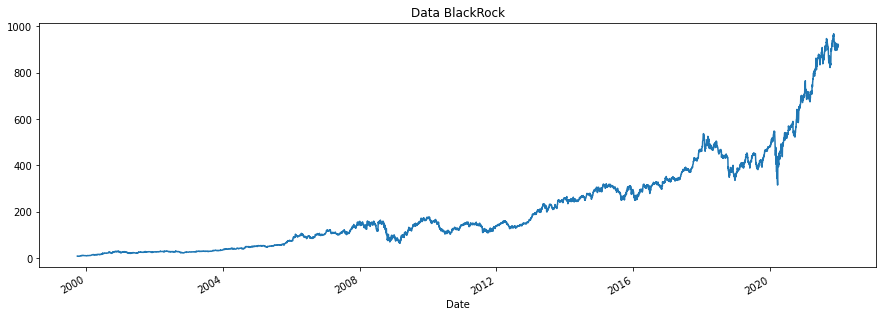

In [7]:
data_blk['Adj Close'].plot(figsize=(15, 5))
plt.title("Data BlackRock")

Text(0.5, 1.0, 'Data Ethereum')

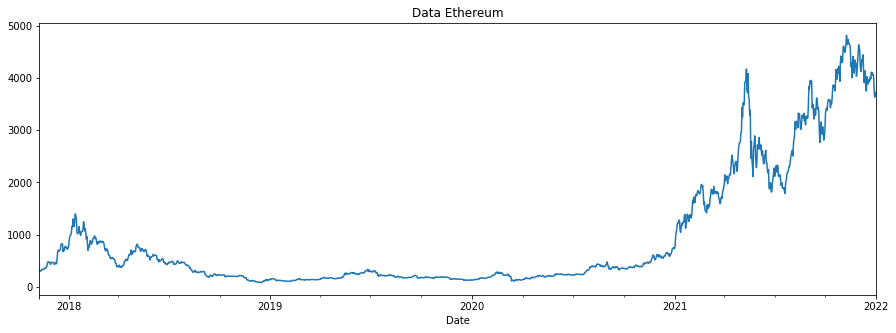

In [8]:
data_eth['Adj Close'].plot(figsize=(15, 5))
plt.title("Data Ethereum")

Text(0.5, 1.0, 'Data Luna')

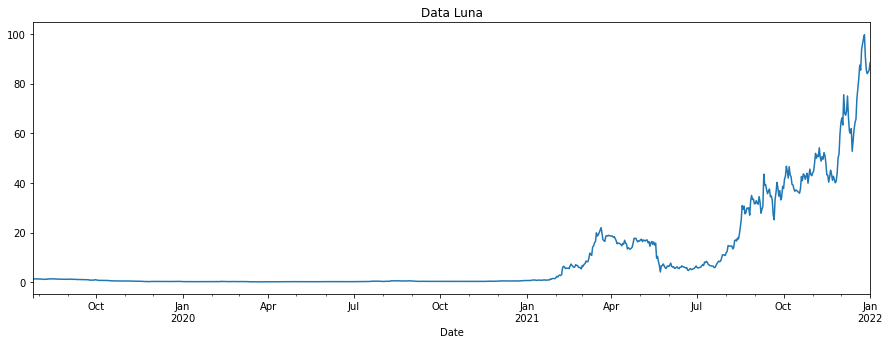

In [9]:
data_luna['Adj Close'].plot(figsize=(15, 5))
plt.title("Data Luna")

Text(0.5, 1.0, 'Data of 3 Assets')

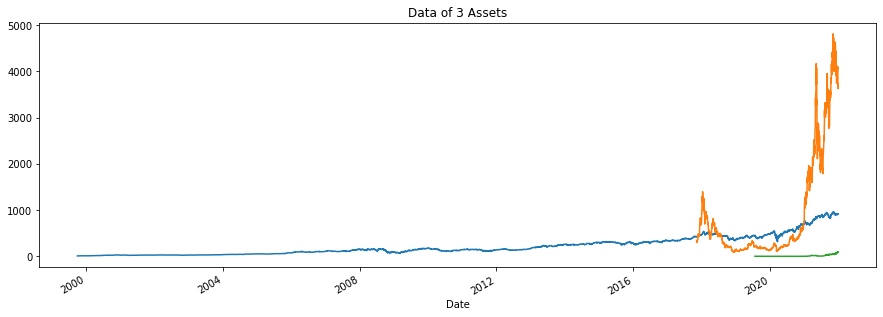

In [10]:
data_blk['Adj Close'].plot(figsize=(15, 5))
data_eth['Adj Close'].plot(figsize=(15, 5))
data_luna['Adj Close'].plot(figsize=(15, 5))
plt.title("Data of 3 Assets")

In [11]:
data_blk.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-27,918.799988,923.130005,912.000000,922.570007,922.570007,410900
2021-12-28,923.780029,929.059998,921.130005,921.820007,921.820007,385200
2021-12-29,921.270020,922.960022,907.679993,909.719971,909.719971,392000
2021-12-30,911.719971,918.059998,906.469971,913.760010,913.760010,315900
2021-12-31,915.340027,919.820007,913.500000,915.559998,915.559998,215100


### Calculate Returns

In [12]:
## pandas.Dataframe.shift(# lags)
## Using shift(1), we can get the row just above the present row. Here, # lags is 1.
## log() is a function given in numpy package in python. It calculates the natural log of the value given inside it.
#data_blk['Log Return'] = np.log(PG['Adj Close']/PG['Adj Close'].shift(1))

def calculate_returns (dataframe):
  dataframe['LOG_RETURN'] = np.log(dataframe['Adj Close'] / dataframe['Adj Close'].shift(1))
  return

In [13]:
calculate_returns(data_blk)

In [14]:
calculate_returns(data_eth)
calculate_returns(data_luna)

In [15]:
len(data_luna)

891

### Trim data for 2 years

In [16]:
data_blk_trim = data_blk.iloc[-910:]
data_eth_trim = data_eth.iloc[-len(data_luna):]
data_luna_trim = data_luna.iloc[-len(data_luna):]

Text(0.5, 1.0, 'Prices of 3 Assets')

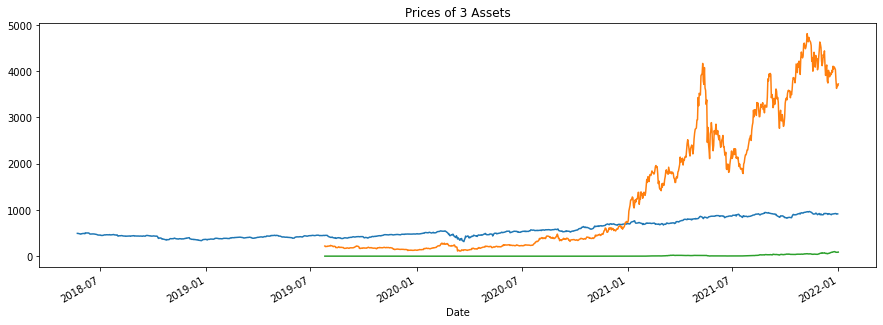

In [17]:
data_blk_trim['Adj Close'].plot(figsize=(15, 5))
data_eth_trim['Adj Close'].plot(figsize=(15, 5))
data_luna_trim['Adj Close'].plot(figsize=(15, 5))
plt.title("Prices of 3 Assets")

Text(0.5, 1.0, 'Returns of 3 Assets')

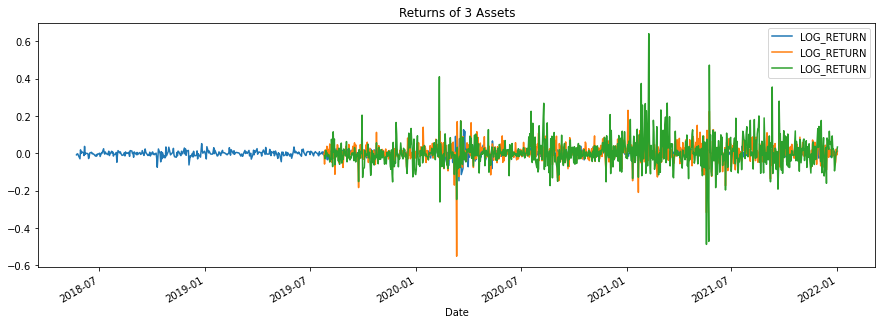

In [18]:
data_blk_trim['LOG_RETURN'].plot(figsize=(15, 5))
data_eth_trim['LOG_RETURN'].plot(figsize=(15, 5))
data_luna_trim['LOG_RETURN'].plot(figsize=(15, 5))
plt.legend()
plt.title("Returns of 3 Assets")

### Seasonal Plots

First we turn our index into another column:

In [19]:
import matplotlib as mpl

def plot_seasonal_months(dataframe, ticker, columnName):
  '''
  DESC.: Function that takes a dataframe and a specified column in order to plot
          seasonality by Year (lines) and months (x axis)
  INPUT: dataframe (pandas, from yfinance)
  INPUT: ticker (str)
  INPUT: columnName (str)
  OUTPUT: plot with seasonality by year and month
  '''
  ## Turn date index into column
  dataframe_no_index = dataframe.reset_index()

  ## Prepare data
  dataframe_no_index['year'] = [d.year for d in dataframe_no_index.Date]
  dataframe_no_index['month'] = [d.strftime('%b') for d in dataframe_no_index.Date]
  years = dataframe_no_index['year'].unique()

  ## Prep Colors
  np.random.seed(100)
  mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

  # Draw Plot
  plt.figure(figsize=(16,12), dpi= 80)
  for i, y in enumerate(years):
      if i > 0:        
          plt.plot('month', columnName,
                   data=dataframe_no_index.loc[dataframe_no_index.year==y, :],
                   color=mycolors[i],
                   label=y)
          plt.text(dataframe_no_index.loc[dataframe_no_index.year==y, :].shape[0]-.9,
                   dataframe_no_index.loc[dataframe_no_index.year==y,
                                          columnName][-1:].values[0],
                    y,
                    fontsize=12,
                    color=mycolors[i])

  # Decoration
  plt.gca().set(xlim=(-0.3, 11), ylim=(2, 30), ylabel='$'+ ticker + ' Prices$', xlabel='$Month$')
  plt.yticks(fontsize=12, alpha=.7)
  plt.title("Seasonal Plot of " + ticker + " Time Series", fontsize=20)
  plt.show()


In [20]:
 # plot_seasonal_months(data_blk_trim, 'BLK', 'Adj Close')

Likewise, you can do a month-wise boxplot to visualize the monthly distributions. Boxplot of Month-wise (Seasonal) and Year-wise (trend) Distribution You can group the data at seasonal intervals and see how the values are distributed within a given year or month and how it compares over time.

In [21]:
import seaborn as sns

def plot_seasonal_boxplots(dataframe, ticker, column_name):
  '''
  DESC.: Function that takes a dataframe and a specified column in order to plot
          seasonal boxplots for trend (yearly) and seasonality (montly)
  INPUT: dataframe (pandas, from yfinance)
  INPUT: ticker (str)
  INPUT: column_name (str)
  OUTPUT: plots with trend and seasonality
  '''
  ## Turn date index into column
  dataframe_no_index = dataframe.reset_index()

  ## Prepare data
  dataframe_no_index['year'] = [d.year for d in dataframe_no_index.Date]
  dataframe_no_index['month'] = [d.strftime('%b') for d in dataframe_no_index.Date]
  years = dataframe_no_index['year'].unique()

  # Draw Plot
  fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
  sns.boxplot(x='year',
              y=column_name,
              data=dataframe_no_index,
              ax=axes[0])
  sns.boxplot(x='month',
              y='Adj Close',
              data=dataframe_no_index.loc[~dataframe_no_index.year.isin([np.min(dataframe_no_index.year), np.max(dataframe_no_index.year)]), :])
  
  # Set Title
  axes[0].set_title("Year-wise Box Plot for "+ticker+"\n(The Trend)", fontsize=18); 
  axes[1].set_title('Month-wise Box Plot for '+ticker+'\n(The Seasonality)', fontsize=18)
  plt.show()

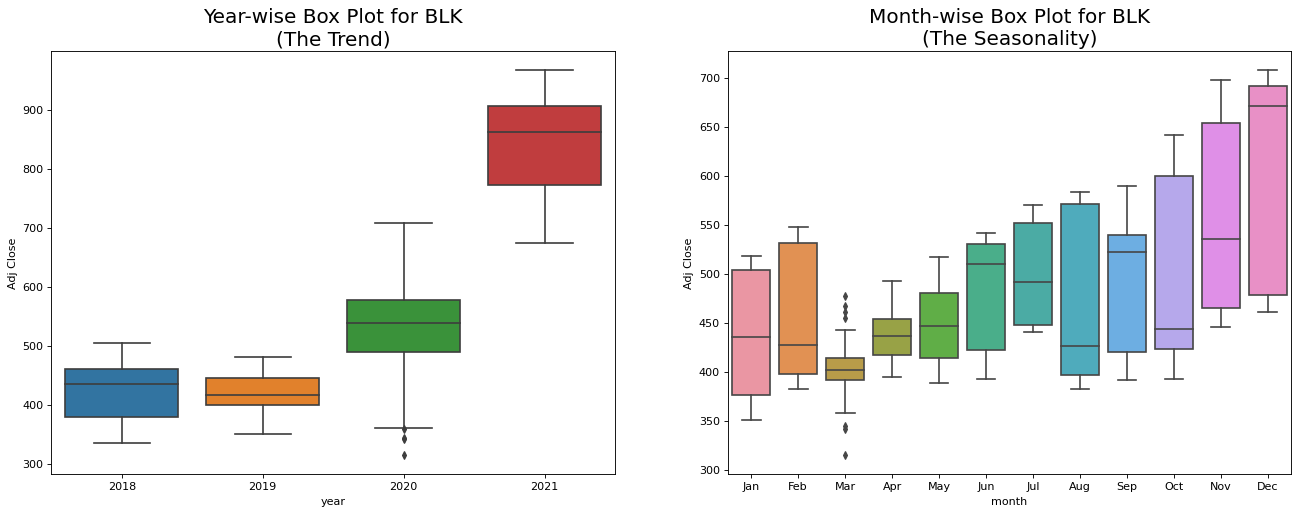

In [22]:
plot_seasonal_boxplots(data_blk_trim, 'BLK', 'Adj Close')

### Additive and Multiplicative Time Series

Most often, we use this decompositions as follows:

- **Additive:** in case the series has constant variance

- **Multiplicative:** in case the series has non-constant variance along time

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

def series_decomposition(dataframe, ticker, column_name, period):
  '''
  DESC.: Function that takes a dataframe and a specified column in order to plot
         both, multiplicative and additive decompositions
  INPUT: dataframe (pandas, taken from yfinance)
  INPUT: ticker (str)
  INPUT: column_name (str)
  INPUT: period (int)
  OUTPUT: plot with multiplicative and additive decompositions
  '''
  # Multiplicative Decomposition 
  result_mul = seasonal_decompose(dataframe[column_name], model='multiplicative', extrapolate_trend='freq', period=period)

  # Additive Decomposition
  result_add = seasonal_decompose(dataframe[column_name], model='additive', extrapolate_trend='freq', period=period)

  # Plot
  plt.rcParams.update({'figure.figsize': (10,10)})
  result_mul.plot().suptitle('Multiplicative Decompose for '+ticker, fontsize=22)
  result_add.plot().suptitle('Additive Decompose for '+ticker, fontsize=22)
  plt.show()

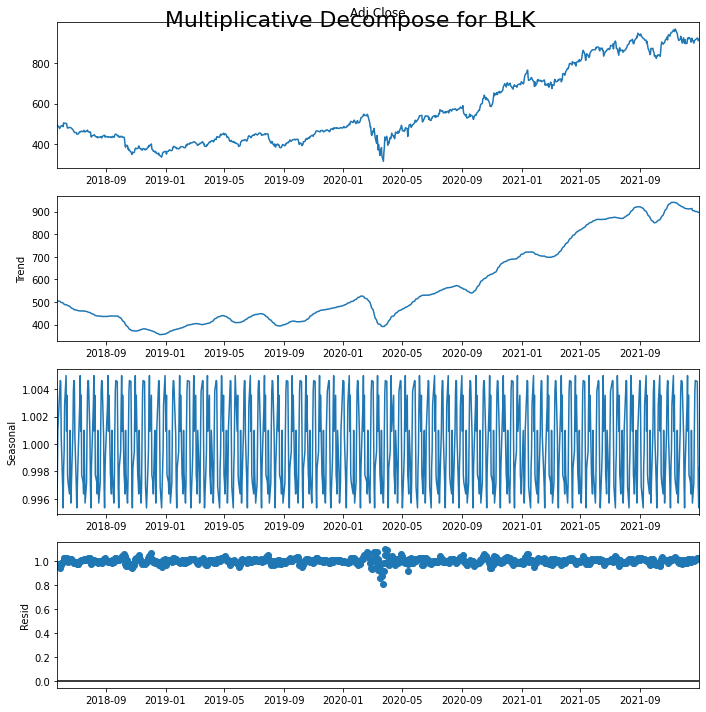

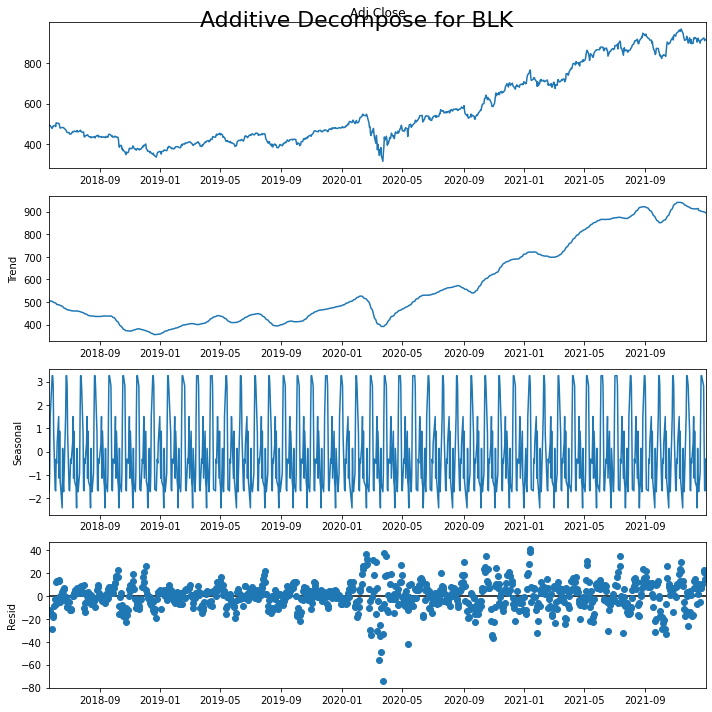

In [24]:
series_decomposition(data_blk_trim, 'BLK', 'Adj Close', 20)

Setting extrapolate_trend='freq' takes care of any missing values in the trend and residuals at the beginning of the series.

We should also aim for seeing no patterns and mean around 0 from the residuals.

 The numerical output of the trend, seasonal and residual components are stored in the result_mul output itself. Let’s extract them and put it in a dataframe:

In [25]:
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

NameError: ignored

We can actually add this to our previous function:

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

def series_decomposition(dataframe, ticker, column_name, period):
  '''
  DESC.: Function that takes a dataframe and a specified column in order to plot
         both, multiplicative and additive decompositions
  INPUT: dataframe (pandas, taken from yfinance)
  INPUT: ticker (str)
  INPUT: column_name (str)
  INPUT: period (int)
  OUTPUT: plot with multiplicative and additive decompositions
  '''
  ## Multiplicative Decomposition 
  result_mul = seasonal_decompose(dataframe[column_name], model='multiplicative', extrapolate_trend='freq', period=period)

  ## Actual Values = Product of (Seasonal * Trend * Resid)
  df_mul_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
  df_mul_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']

  ## Additive Decomposition
  result_add = seasonal_decompose(dataframe[column_name], model='additive', extrapolate_trend='freq', period=period)

  ## Actual Values = Sum of (Seasonal + Trend + Resid)
  df_add_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
  df_add_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']


  # Plot
  plt.rcParams.update({'figure.figsize': (10,10)})
  result_mul.plot().suptitle('Multiplicative Decompose for '+ticker, fontsize=22)
  result_add.plot().suptitle('Additive Decompose for '+ticker, fontsize=22)
  plt.show()

  return df_mul_reconstructed, df_add_reconstructed

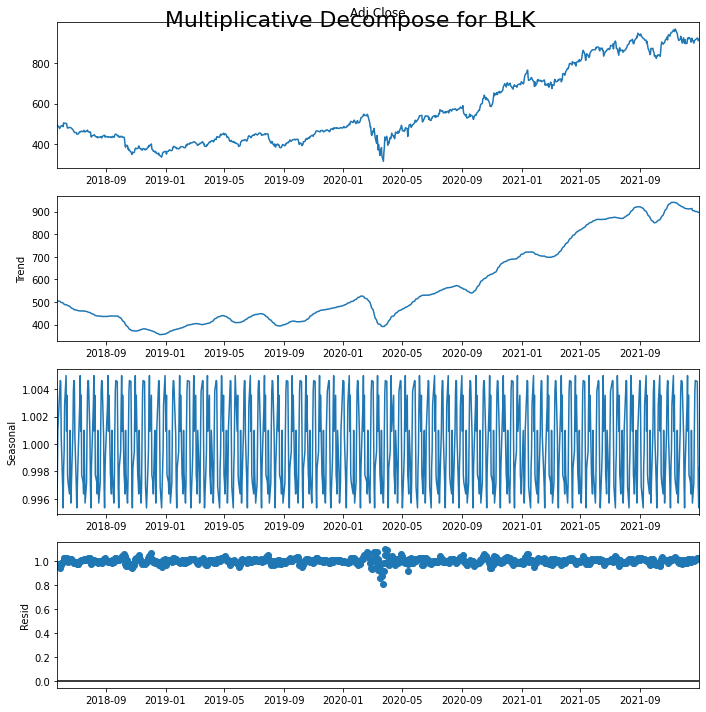

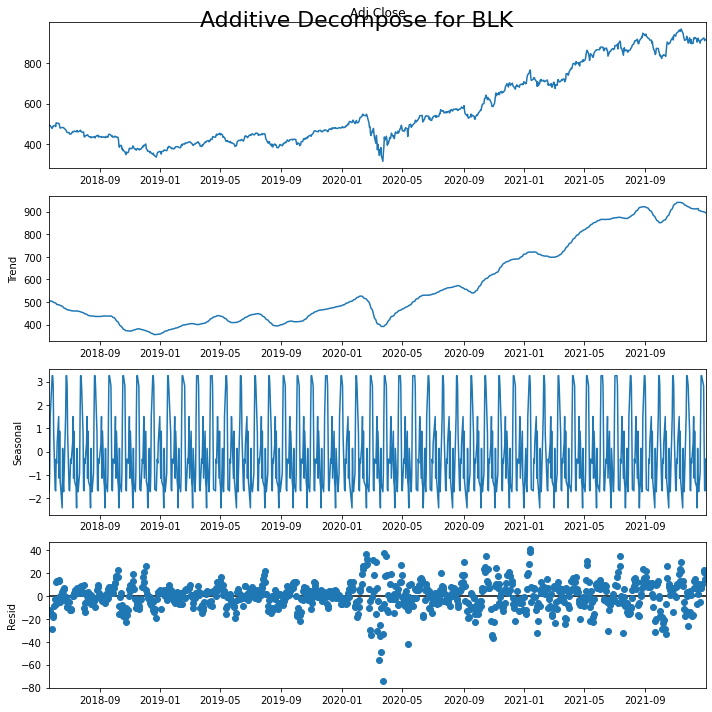

In [27]:
df_mul_blk, df_add_blk = series_decomposition(data_blk_trim, 'BLK', 'Adj Close', 20)

### Test for Stationarity

Another method is to split the series into 2 or more contiguous parts and computing the summary statistics like the mean, variance and the autocorrelation. If the stats are quite different, then the series is not likely to be stationary. Nevertheless, you need a method to quantitatively determine if a given series is stationary or not. This can be done using statistical tests called ‘Unit Root Tests’. There are multiple variations of this, where the tests check if a time series is non-stationary and possess a unit root. There are multiple implementations of Unit Root tests like:

1. Augmented Dickey Fuller test (ADH Test)


2. Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)


3. Philips Perron test (PP Test)


The most commonly used is the ADF test, where the null hypothesis is the time series possesses a unit root and is non-stationary. So, id the P-Value in ADH test is less than the significance level (0.05), you reject the null hypothesis. The KPSS test, on the other hand, is used to test for trend stationarity. The null hypothesis and the P-Value interpretation is just the opposite of ADH test. The below code implements these two tests using statsmodels package in python.

In [28]:
from statsmodels.tsa.stattools import adfuller, kpss

def stationarity_tests(dataframe, ticker, column_name, sig_level):
  '''
  DESC.: Function that takes a dataframe, a column and a significance level in
          order to perform ADF and KPSS tests for stationarity
  INPUT: dataframe (pandas, from yfinance)
  INPUT: ticker (str)
  INPUT: column_name (str)
  INPUT: sig_level (float)
  OUTPUT: Interpretation fo ADF and KPSS tests
  '''
  ## ADF Test
  result_adf = adfuller(dataframe[column_name].values, autolag='AIC')
  print("*** ADF Test ***")
  print("\nH0: Series has a unit root and is non-stationary")
  print(f'ADF Statistic: {result_adf[0]}')
  print(f'p-value: {result_adf[1]}')
  print("p-value interpretation:")
  if result_adf[1] < sig_level:
    print(ticker+" series is STATIONARY (reject H0)")
  else:
    print(ticker+" series is NON-STATIONARY (don´t reject H0)")
  print("\n")
  for key, value in result_adf[4].items():
      print('Critial Values:')
      print(f'   {key}, {value}')
  print("______________________________________________________")
  print("\n")

  ## KPSS Test
  print("*** KPSS Test ***")
  result_kpss = kpss(dataframe[column_name].values, regression='c')
  print('\nKPSS Statistic: %f' % result_kpss[0])
  print('p-value: %f' % result_kpss[1])
  print('p_value Interpretation:')
  if result_kpss[1] > sig_level:
    print(ticker+" series trend is STATIONARY (don´t reject H0)")
  else:
    print(ticker+" series trend is NON-STATIONARY (reject H0)")
  print("\n")
  for key, value in result_kpss[3].items():
      print('Critial Values:')
      print(f'   {key}, {value}')


In [29]:
stationarity_tests(data_blk_trim, 'BLK', 'Adj Close', 0.05)

*** ADF Test ***

H0: Series has a unit root and is non-stationary
ADF Statistic: 0.15897626123244488
p-value: 0.9698645264833162
p-value interpretation:
BLK series is NON-STATIONARY (don´t reject H0)


Critial Values:
   1%, -3.437628610719785
Critial Values:
   5%, -2.8647531504389767
Critial Values:
   10%, -2.5684808963896324
______________________________________________________


*** KPSS Test ***

KPSS Statistic: 4.169533
p-value: 0.010000
p_value Interpretation:
BLK series trend is NON-STATIONARY (reject H0)


Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2012: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


### How to De-trend a Time Series

Detrending a time series is to remove the trend component from a time series. But how to extract the trend? There are multiple approaches.

- Subtract the line of best fit from the time series. The line of best fit may be obtained from a linear regression model with the time steps as the predictor. For more complex trends, you may want to use quadratic terms (x^2) in the model.


- Subtract the trend component obtained from time series decomposition we saw earlier.


- Subtract the mean


- Apply a filter like Baxter-King filter(statsmodels.tsa.filters.bkfilter) or the Hodrick-Prescott Filter (statsmodels.tsa.filters.hpfilter) to remove the moving average trend lines or the cyclical components.

Text(0.5, 1.0, 'BLK detrended by subtracting the least squares fit')

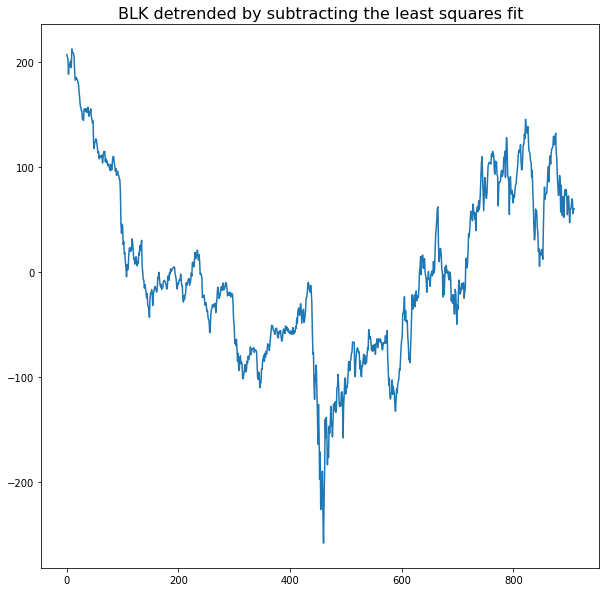

In [30]:
## Using scipy: Subtract the line of best fit
from scipy import signal

detrended = signal.detrend(data_blk_trim['Adj Close'].values)
plt.plot(detrended)
plt.title('BLK detrended by subtracting the least squares fit', fontsize=16)

Text(0.5, 1.0, 'BLK detrended by subtracting the trend component')

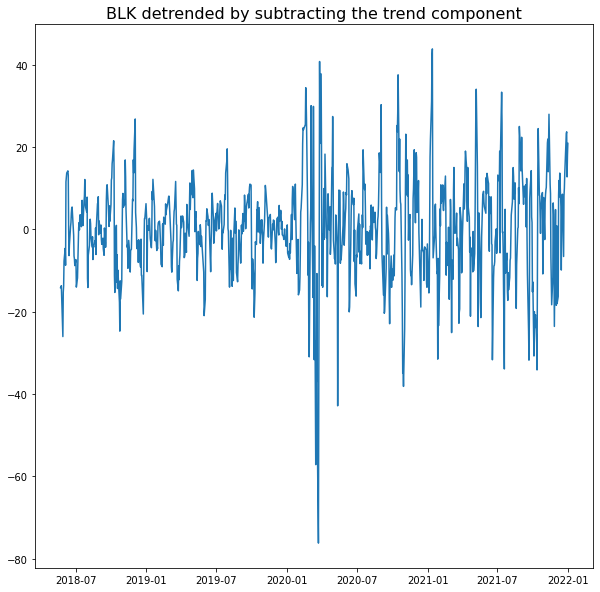

In [31]:
# Using statmodels: Subtracting the Trend Component.
from statsmodels.tsa.seasonal import seasonal_decompose

result_add = seasonal_decompose(data_blk_trim['Adj Close'], model='additive', extrapolate_trend='freq', period=20)
detrended = data_blk_trim['Adj Close'].values - result_add.trend
plt.plot(detrended)
plt.title('BLK detrended by subtracting the trend component', fontsize=16)


Text(0.5, 1.0, 'BLK detrended by substracting the mean')

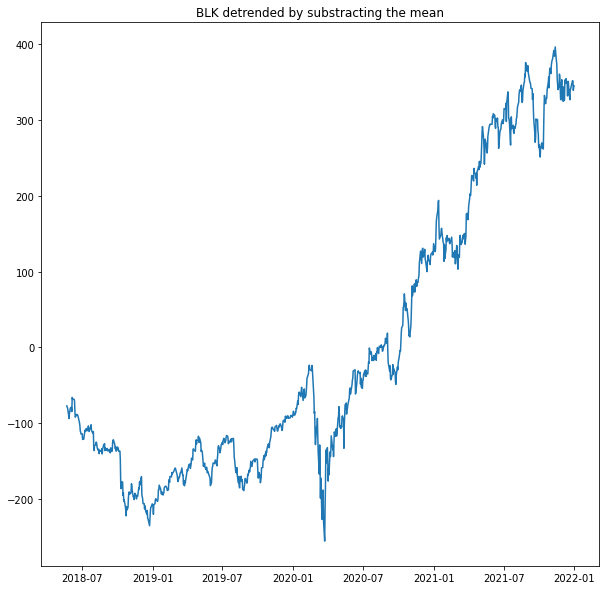

In [32]:
## Third method: Substract the mean

mean1 = data_blk_trim['Adj Close'].mean()
data_substract_mean = data_blk_trim['Adj Close'] - mean1

plt.plot(data_substract_mean)
plt.title("BLK detrended by substracting the mean")

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

def detrend_series(dataframe, decomposed_dataframe, column_name, ticker):
  '''
  DESC.: Function that takes the original dataframe along with a the column that
          was passed through the series_decomposition() function, as well as the
          dataframe resulting from that function and returns a de-trended
          dataframe 
  INPUT: dataframe (pandas, from yfinance)
  INPUT: decomposed_dataframe (dataframe, from series_decomposition())
  INPUT: column_name (str)
  INPUT: ticker (str)
  OUTPUT: de-trended dataframe
  '''
  ## Substract trend component from original series
  detrended = dataframe[column_name].values - decomposed_dataframe.trend

  ## plot detrended series
  plt.plot(detrended)
  plt.title(ticker+' detrended by subtracting the trend component', fontsize=16)

  return detrended



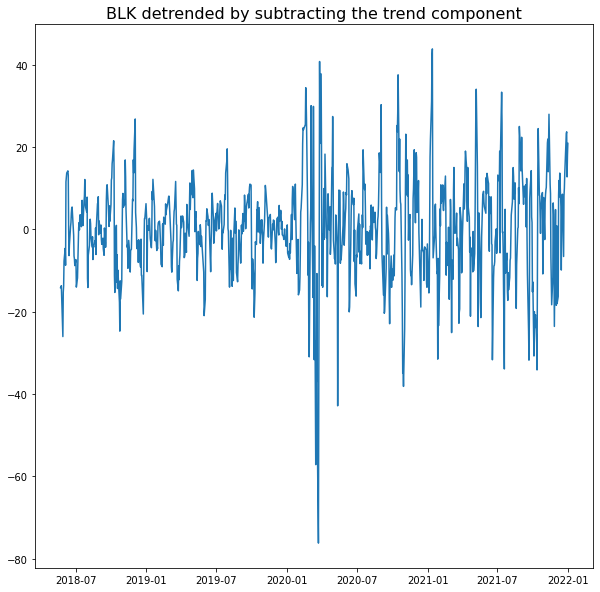

In [34]:
df_detrended_blk = detrend_series(data_blk_trim, df_add_blk, 'Adj Close', 'BLK')

### How to De-seasonalize a Time Series

There are multiple approaches to deseasonalize a time series as well. Below are a few:

- 1. Take a moving average with length as the seasonal window. This will smoothen in series in the process.


- 2. Seasonal difference the series (subtract the value of previous season from the current value)


- 3. Divide the series by the seasonal index obtained from STL decomposition

If dividing by the seasonal index does not work well, try taking a log of the series and then do the deseasonalizing. You can later restore to the original scale by taking an exponential.

[]

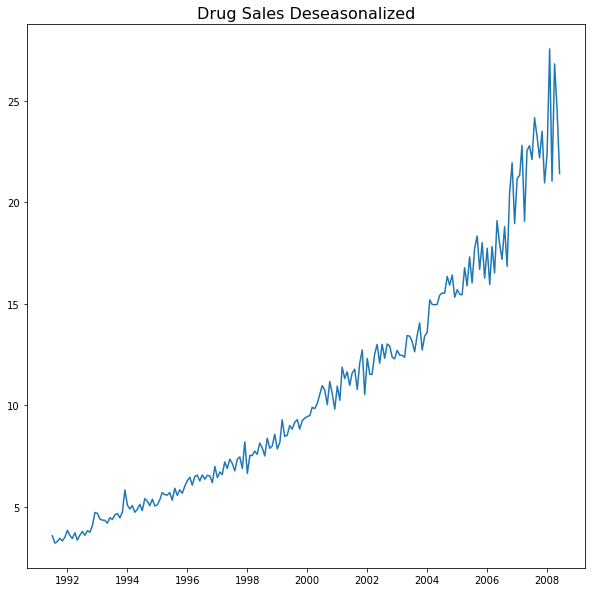

In [35]:
# Subtracting the Trend Component.
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Time Series Decomposition
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')

# Deseasonalize
deseasonalized = df.value.values / result_mul.seasonal

# Plot
plt.plot(deseasonalized)
plt.title('Drug Sales Deseasonalized', fontsize=16)
plt.plot()

### Test for Seasonality

The common way is to plot the series and check for repeatable patterns in fixed time intervals. So, the types of seasonality is determined by the clock or the calendar:

- Hour of day
- Day of month
- Weekly
- Monthly
- Yearly 

However, if you want a more definitive inspection of the seasonality, use the Autocorrelation Function (ACF) plot. More on the ACF in the upcoming sections. But when there is a strong seasonal pattern, the ACF plot usually reveals definitive repeated spikes at the multiples of the seasonal window. For example, the drug sales time series is a monthly series with patterns repeating every year. So, you can see spikes at 12th, 24th, 36th.. lines. I must caution you that in real word datasets such strong patterns is hardly noticed and can get distorted by any noise, so you need a careful eye to capture these patterns.

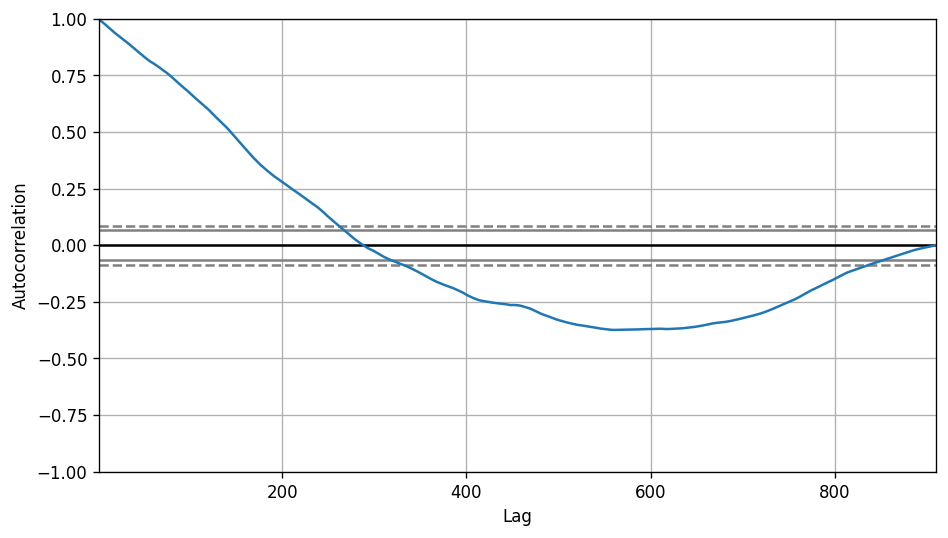

In [36]:
from pandas.plotting import autocorrelation_plot

## Draw Plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(data_blk_trim['Adj Close'].tolist())

For every spike we see in this plot, those are the points in which seasonality is present. If we had monthly data and a seasonal pattern, we would appreciate spikes at the 12, 24, 36 and such values in the Lag axis.

Alternately, if you want a statistical test, the CHTest can determine if seasonal differencing is required to stationarize the series

### Missing Values in Time Series

Sometimes, your time series will have missing dates/times. That means, the data was not captured or was not available for those periods. It could so happen the measurement was zero on those days, in which case, case you may fill up those periods with zero. Secondly, when it comes to time series, you should typically NOT replace missing values with the mean of the series, especially if the series is not stationary. What you could do instead for a quick and dirty workaround is to forward-fill the previous value. However, depending on the nature of the series, you want to try out multiple approaches before concluding. Some effective alternatives to imputation are:

- Backward Fill
- Linear Interpolation
- Quadratic interpolation
- Mean of nearest neighbors
- Mean of seasonal couterparts

To measure the imputation performance, I manually introduce missing values to the time series, impute it with above approaches and then measure the mean squared error of the imputed against the actual values.

In [37]:
# # Generate dataset
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
df_orig = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date').head(100)
df = pd.read_csv('datasets/a10_missings.csv', parse_dates=['date'], index_col='date')

fig, axes = plt.subplots(7, 1, sharex=True, figsize=(10, 12))
plt.rcParams.update({'xtick.bottom' : False})

## 1. Actual -------------------------------
df_orig.plot(title='Actual', ax=axes[0], label='Actual', color='red', style=".-")
df.plot(title='Actual', ax=axes[0], label='Actual', color='green', style=".-")
axes[0].legend(["Missing Data", "Available Data"])

## 2. Forward Fill --------------------------
df_ffill = df.ffill()
error = np.round(mean_squared_error(df_orig['value'], df_ffill['value']), 2)
df_ffill['value'].plot(title='Forward Fill (MSE: ' + str(error) +")", ax=axes[1], label='Forward Fill', style=".-")

## 3. Backward Fill -------------------------
df_bfill = df.bfill()
error = np.round(mean_squared_error(df_orig['value'], df_bfill['value']), 2)
df_bfill['value'].plot(title="Backward Fill (MSE: " + str(error) +")", ax=axes[2], label='Back Fill', color='firebrick', style=".-")

## 4. Linear Interpolation ------------------
df['rownum'] = np.arange(df.shape[0])
df_nona = df.dropna(subset = ['value'])
f = interp1d(df_nona['rownum'], df_nona['value'])
df['linear_fill'] = f(df['rownum'])
error = np.round(mean_squared_error(df_orig['value'], df['linear_fill']), 2)
df['linear_fill'].plot(title="Linear Fill (MSE: " + str(error) +")", ax=axes[3], label='Cubic Fill', color='brown', style=".-")

## 5. Cubic Interpolation --------------------
f2 = interp1d(df_nona['rownum'], df_nona['value'], kind='cubic')
df['cubic_fill'] = f2(df['rownum'])
error = np.round(mean_squared_error(df_orig['value'], df['cubic_fill']), 2)
df['cubic_fill'].plot(title="Cubic Fill (MSE: " + str(error) +")", ax=axes[4], label='Cubic Fill', color='red', style=".-")

# Interpolation References:
# https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html
# https://docs.scipy.org/doc/scipy/reference/interpolate.html

## 6. Mean of 'n' Nearest Past Neighbors ------
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n/2)
            lower = np.max([0, int(i-n_by_2)])
            upper = np.min([len(ts)+1, int(i+n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out

df['knn_mean'] = knn_mean(df.value.values, 8)
error = np.round(mean_squared_error(df_orig['value'], df['knn_mean']), 2)
df['knn_mean'].plot(title="KNN Mean (MSE: " + str(error) +")", ax=axes[5], label='KNN Mean', color='tomato', alpha=0.5, style=".-")

## 7. Seasonal Mean ----------------------------
def seasonal_mean(ts, n, lr=0.7):
    """
    Compute the mean of corresponding seasonal periods
    ts: 1D array-like of the time series
    n: Seasonal window length of the time series
    """
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            ts_seas = ts[i-1::-n]  # previous seasons only
            if np.isnan(np.nanmean(ts_seas)):
                ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  # previous and forward
            out[i] = np.nanmean(ts_seas) * lr
    return out

df['seasonal_mean'] = seasonal_mean(df.value, n=12, lr=1.25)
error = np.round(mean_squared_error(df_orig['value'], df['seasonal_mean']), 2)
df['seasonal_mean'].plot(title="Seasonal Mean (MSE: " + str(error) +")", ax=axes[6], label='Seasonal Mean', color='blue', alpha=0.5, style=".-")

FileNotFoundError: ignored

### Autocorrelation and Partial Autocorrelation

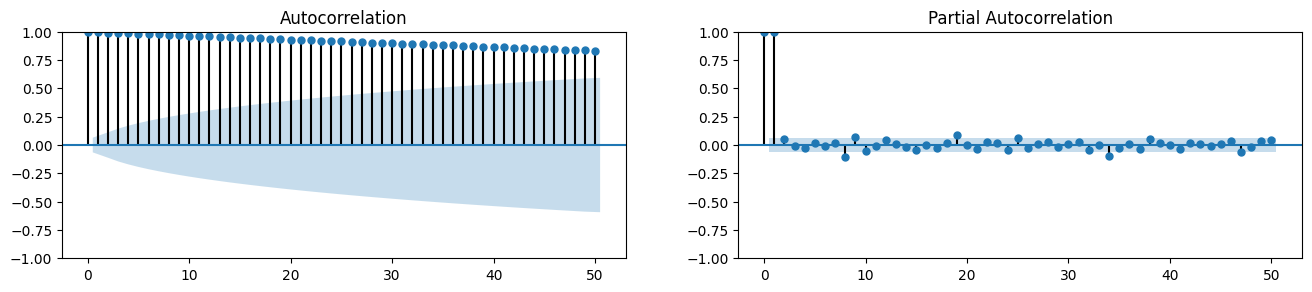

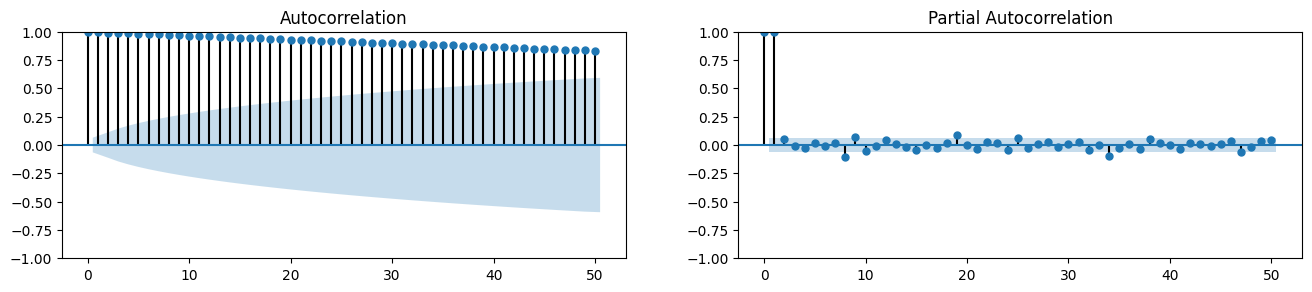

In [38]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(data_blk_trim['Adj Close'].tolist(), lags=50, ax=axes[0])
plot_pacf(data_blk_trim['Adj Close'].tolist(), lags=50, ax=axes[1])

### Lag Plots

A Lag plot is a scatter plot of a time series against a lag of itself. It is normally used to check for autocorrelation. If there is any pattern existing in the series like the one you see below, the series is autocorrelated. If there is no such pattern, the series is likely to be random white noise. In below example on Sunspots area time series, the plots get more and more scattered as the n_lag increases.

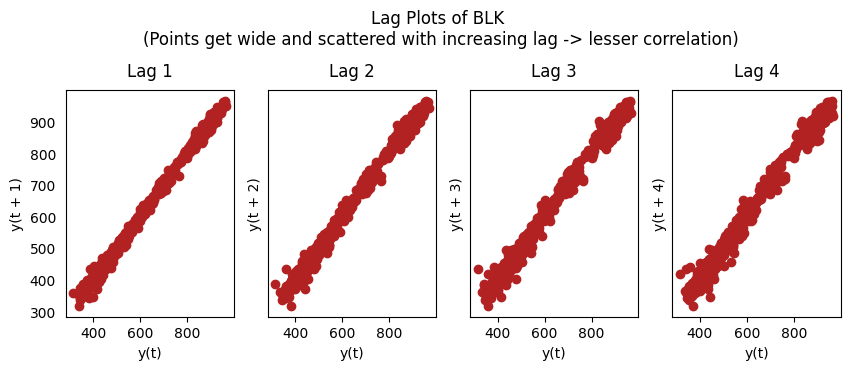

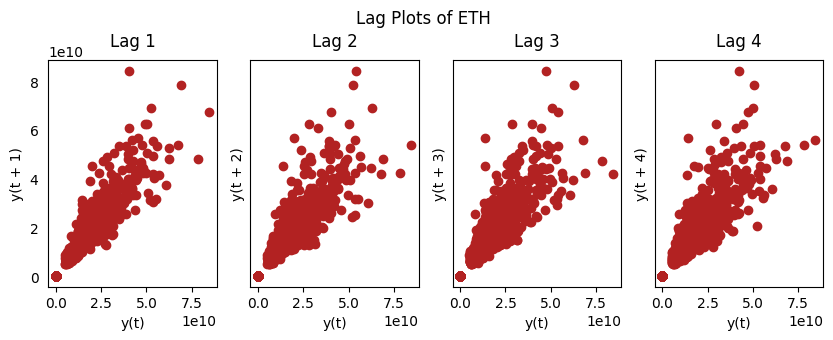

In [39]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})


# Plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:8]):
    lag_plot(data_blk_trim['Adj Close'], lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of BLK \n(Points get wide and scattered with increasing lag -> lesser correlation)\n', y=1.15)    

fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:8]):
    lag_plot(data_eth_trim, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of ETH', y=1.05)    
plt.show()

### Estimate Forecastability of a Time Series

The more regular and repeatable patterns a time series has, the easier it is to forecast. The ‘Approximate Entropy’ can be used to quantify the regularity and unpredictability of fluctuations in a time series. The higher the approximate entropy, the more difficult it is to forecast it. 

Another better alternate is the ‘Sample Entropy’. Sample Entropy is similar to approximate entropy but is more consistent in estimating the complexity even for smaller time series. For example, a random time series with fewer data points can have a lower ‘approximate entropy’ than a more ‘regular’ time series, whereas, a longer random time series will have a higher ‘approximate entropy’. Sample Entropy handles this problem nicely. See the demonstration below.

In [40]:
rand_small = np.random.randint(0, 100, size=36)
rand_big = np.random.randint(0, 100, size=136)

def ApEn(U, m, r):
    """Compute Aproximate entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m+1) - _phi(m))

print(ApEn(data_blk_trim['Adj Close'], m=2, r=0.2*np.std(data_blk_trim['Adj Close'])))     # 0.651
print(ApEn(data_eth_trim['Adj Close'], m=2, r=0.2*np.std(data_eth_trim['Adj Close'])))   # 0.537
print(ApEn(rand_small, m=2, r=0.2*np.std(rand_small))) # 0.143
print(ApEn(rand_big, m=2, r=0.2*np.std(rand_big)))     # 0.716

0.12086534682410699
0.1364874669529108
0.20044343724868074
0.6384546700468539


In [41]:
def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

print(SampEn(data_blk_trim['Adj Close'], m=2, r=0.2*np.std(data_blk_trim['Adj Close'])))      # 0.78
print(SampEn(data_eth_trim['Adj Close'], m=2, r=0.2*np.std(data_eth_trim['Adj Close'])))    # 0.41
print(SampEn(rand_small, m=2, r=0.2*np.std(rand_small)))  # 1.79
print(SampEn(rand_big, m=2, r=0.2*np.std(rand_big)))      # 2.42

0.09723543329954898
0.02348607835471709
inf
1.7443572303334711


### Why and How to Smoothen a Time Series

Smoothening of a time series may be useful in:

- Reducing the effect of noise in a signal get a fair approximation of the noise-filtered series.


- The smoothed version of series can be used as a feature to explain the original series itself.


- Visualize the underlying trend better

So how to smoothen a series? Let’s discuss the following methods:

1. Take a moving average
2. Do a LOESS smoothing (Localized Regression)
3. Do a LOWESS smoothing (Locally Weighted Regression)

Moving average is nothing but the average of a rolling window of defined width. But you must choose the window-width wisely, because, large window-size will over-smooth the series. For example, a window-size equal to the seasonal duration (ex: 12 for a month-wise series), will effectively nullify the seasonal effect. 

LOESS, short for ‘LOcalized regrESSion’ fits multiple regressions in the local neighborhood of each point. It is implemented in the statsmodels package, where you can control the degree of smoothing using frac argument which specifies the percentage of data points nearby that should be considered to fit a regression model.

In [50]:
from statsmodels.nonparametric.smoothers_lowess import lowess
plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})

def smoothing_series(dataframe, ticker, column_name, pct1, pct2, ma_window):
  '''
  DESC.: Function that takes a dataframe, an specified column, 2 different
          percentages for lowess and one value for the window for moving average
          and plots the smoothed time series.
  INPUT: dataframe (pandas, taken from yfinance)
  INPUT: ticker (str)
  INPUT: column_name (str)
  INPUT: pct1 (float)
  INPUT: pct2 (float)
  INPUT: ma_window (int)
  OUTPUT: Plots the 3 smoothed time series and outputs the 3 different dataframes
  '''
  # Import
  df_orig = dataframe[column_name]

  # 1. Moving Average
  df_ma = df_orig.rolling(ma_window, center=True, closed='both').mean()

  # 2. Loess Smoothing (5% and 15%)
  df_loess_a = pd.DataFrame(lowess(df_orig, np.arange(len(df_orig)), frac=pct1)[:, 1], index=df_orig.index, columns=['value'])
  df_loess_b = pd.DataFrame(lowess(df_orig, np.arange(len(df_orig)), frac=pct2)[:, 1], index=df_orig.index, columns=['value'])

  # Plot
  fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)
  df_orig.plot(ax=axes[0], color='k', title='Original Series')
  df_loess_a['value'].plot(ax=axes[1], title='Loess Smoothed ' + str(pct1*100) + '%')
  df_loess_b['value'].plot(ax=axes[2], title='Loess Smoothed ' + str(pct2*100) + '%')
  df_ma.plot(ax=axes[3], title='Moving Average '+str(ma_window))
  fig.suptitle('Smoothed ' +ticker+ ' Time Series', y=0.95, fontsize=14)
  plt.show()

  return df_loess_a, df_loess_b, df_ma
 

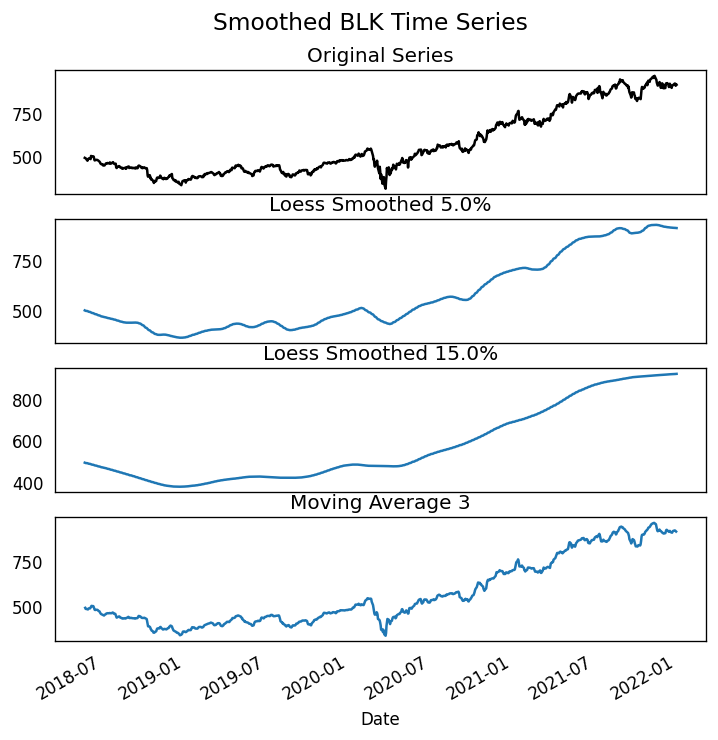

In [51]:
df_loess_5_blk, df_loess_15_blk, df_ma_3_blk = smoothing_series(data_blk_trim, 'BLK', 'Adj Close', 0.05, 0.15, 3)

### Granger Causality test to know if one time series is helpful in forecasting another

Granger causality test is used to determine if one time series will be useful to forecast another. How does Granger causality test work? It is based on the idea that if $X$ causes $Y$, then the forecast of $Y$ based on previous values of $Y$ AND the previous values of $X$ should outperform the forecast of $Y$ based on previous values of $Y$ alone. So, understand that Granger causality should not be used to test if a lag of $Y$ causes $Y$.

Instead, it is generally used on exogenous (not $Y$ lag) variables only. It is nicely implemented in the statsmodel package. It accepts a 2D array with 2 columns as the main argument. The values are in the first column and the predictor ($X$) is in the second column. 

The Null hypothesis is: the series in the second column, does not Granger cause the series in the first. **If the P-Values are less than a significance level (0.05) then you reject the null hypothesis and conclude that the said lag of X is indeed useful.**

The second argument maxlag says till how many lags of Y should be included in the test.

In [59]:
from statsmodels.tsa.stattools import grangercausalitytests

series2 = data_blk_trim
series2['Date'] = series2.index
series2['month'] = series2['Date'].dt.month
grangercausalitytests(series2[['Adj Close', 'month']], maxlag=2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0243  , p=0.8762  , df_denom=906, df_num=1
ssr based chi2 test:   chi2=0.0243  , p=0.8760  , df=1
likelihood ratio test: chi2=0.0243  , p=0.8760  , df=1
parameter F test:         F=0.0243  , p=0.8762  , df_denom=906, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7466  , p=0.4743  , df_denom=903, df_num=2
ssr based chi2 test:   chi2=1.5014  , p=0.4720  , df=2
likelihood ratio test: chi2=1.5002  , p=0.4723  , df=2
parameter F test:         F=0.7466  , p=0.4743  , df_denom=903, df_num=2


{1: ({'lrtest': (0.024348380546143744, 0.8760017471654893, 1),
   'params_ftest': (0.02426834787826365, 0.8762387609658047, 906.0, 1.0),
   'ssr_chi2test': (0.024348706646353305, 0.876000923525489, 1),
   'ssr_ftest': (0.024268347878543556, 0.8762387609652958, 906.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (1.500160743120432, 0.47232858942978295, 2),
   'params_ftest': (0.7465665266727195, 0.4742835292984151, 903.0, 2.0),
   'ssr_chi2test': (1.5014006782254328, 0.4720358517835155, 2),
   'ssr_ftest': (0.7465665266726683, 0.4742835292984391, 903.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

In the above case, the P-Values are Zero for all tests. So the ‘month’ indeed can be used to forecast the Air Passengers.

We create a function that drops the datetime index and leaves it as sequential numbers:

In [25]:
def drop_date_index(dataframe, columnName):
  '''
  DESC.: Function that takes a dataframe and a specified column to 
          transform it into another dataframe with numerical index
  INPUT: dataframe (pandas, from yfinance)
  INPUT: columnName (str)
  OUTPUT: dataframe with numerical index
  '''

  ## Drop index
  series = dataframe.reset_index(drop = True)

  ## Declare as dataframe
  df_series = pd.DataFrame(series[columnName])

  return df_series

In [26]:
## Remove index from dataframe
series1 = data_blk_trim.reset_index(drop=True)

  ## Declare as dataframe
seriesBLK = pd.DataFrame(series1['Adj Close'])

## ARIMA

ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values. 

Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

An ARIMA model is characterized by 3 terms: $p, d, q$

where,

- $p$ is the order of the AR term

- $q$ is the order of the MA term

- $d$ is the number of differencing required to make the time series stationary

If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’.

### Steps

The first step to build an ARIMA model is to make the time series stationary.

Why?

Because, term ‘Auto Regressive’ in ARIMA means it is a linear regression model that uses its own lags as predictors. Linear regression models, as you know, work best when the predictors are not correlated and are independent of each other.

**How to make a series stationary?**

The most common approach is to difference it. That is, subtract the previous value from the current value. Sometimes, depending on the complexity of the series, more than one differencing may be needed.

The value of $d$, therefore, is the minimum number of differencing needed to make the series stationary. And if the time series is already stationary, then $d = 0$.

$p$ is the order of the ‘Auto Regressive’ (AR) term. It refers to the number of lags of $Y$ to be used as predictors. And $q$ is the order of the ‘Moving Average’ (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

### AR and MA Models

A pure **Auto Regressive (AR only) model** is one where $Y_{t}$ depends only on its own lags. That is, $Y_{t}$ is a function of the lags of $Y_{t}$:

$$Y_{t} = \alpha + \beta_{1}Y_{t-1} + \beta_{2}Y_{t-2} + ... + \beta_{p}Y_{t-p} + \epsilon_{1}$$

A pure **Moving Average (MA only) model** is one where $Y_{t}$ depends only on the lagged forecast errors:

$$Y_{t} = \alpha + \epsilon_{t} + \phi_{1}Y_{t-1} + \phi_{2}Y_{t-2} + ... + \phi_{q}Y_{t-q}$$

### ARIMA Model in words

Predicted $Y_{t}$ = Constant + Linear combination Lags of $Y$ (upto $p$ lags) + Linear Combination of Lagged forecast errors (upto $q$ lags)

### Find differencing order $d$ in ARIMA

The purpose of differencing it to make the time series stationary.

But you need to be careful to not over-difference the series. Because, an over differenced series may still be stationary, which in turn will affect the model parameters.

The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.

If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.


In the event, you can’t really decide between two orders of differencing, then go with the order that gives the least standard deviation in the differenced series.

#### Augmented Dickey Fuller Test

First, I am going to check if the series is stationary using the Augmented Dickey Fuller test (adfuller()), from the statsmodels package.

Why?

Because, you need differencing only if the series is non-stationary. Else, no differencing is needed, that is, $d=0$.


The null hypothesis of the ADF test is that the time series is non-stationary. 

So, **if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary**.

If $p-value > 0.05$ we go ahead with finding the order of differencing.


In [27]:
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs
from numpy import log

In [28]:
def ADF_test (dataframe, ticker, alpha_value):
  '''
  DESC: Function that deterines ADF test and tells if differencing is needed
  INPUT: dataframe (pandas)
  INPUT: ticker (str)
  INPUT: alpha_value (float)
  OUTPUT: Print statements with results
  '''
  result = adfuller(dataframe['LOG_RETURN'].dropna())
  print("*** ADF Test for " + ticker + " ***")
  print('ADF Statistic: %f' % result[0])  
  print('p-value: %f' % result[1])
  if result[1] > alpha_value:
    print("Needs differencing")
  else:
    print("No need for differencing")
  print("____________________________")

In [29]:
ADF_test(data_blk_trim, 'BLK', 0.05)

*** ADF Test for BLK ***
ADF Statistic: -8.182438
p-value: 0.000000
No need for differencing
____________________________


In [30]:
ADF_test(data_eth_trim, 'BLK', 0.05)

*** ADF Test for BLK ***
ADF Statistic: -8.869644
p-value: 0.000000
No need for differencing
____________________________


In [31]:
ADF_test(data_luna_trim, 'BLK', 0.05)

*** ADF Test for BLK ***
ADF Statistic: -6.273242
p-value: 0.000000
No need for differencing
____________________________


Notice that if the ADF test is ran on returns, the result is that no differencing is necessary.

But if we use prices, we need differencing since those are non-stationary:

In [32]:
alpha_value = 0.05
result_blk = adfuller(data_blk_trim['Adj Close'].dropna())
print("*** ADF Test for " + 'BLK' + " ***")
print('ADF Statistic: %f' % result_blk[0])  
print('p-value: %f' % result_blk[1])
if result_blk[1] > alpha_value:
  print("Needs differencing")
else:
  print("No need for differencing")
print("____________________________")

*** ADF Test for BLK ***
ADF Statistic: 0.178172
p-value: 0.971010
Needs differencing
____________________________


In [33]:
result_eth = adfuller(data_eth_trim['Adj Close'].dropna())
print("*** ADF Test for " + 'ETH' + " ***")
print('ADF Statistic: %f' % result_eth[0])  
print('p-value: %f' % result_eth[1])
if result_eth[1] > alpha_value:
  print("Needs differencing")
else:
  print("No need for differencing")
print("____________________________")


*** ADF Test for ETH ***
ADF Statistic: -0.104867
p-value: 0.948952
Needs differencing
____________________________


In [34]:
result_luna = adfuller(data_luna_trim['Adj Close'].dropna())
print("*** ADF Test for " + 'LUNA' + " ***")
print('ADF Statistic: %f' % result_luna[0])  
print('p-value: %f' % result_luna[1])
if result_luna[1] > alpha_value:
  print("Needs differencing")
else:
  print("No need for differencing")
print("____________________________")

*** ADF Test for LUNA ***
ADF Statistic: 4.427305
p-value: 1.000000
Needs differencing
____________________________


Since P-value is greater than the significance level, let’s difference the series and see how the autocorrelation plot looks like:

In [35]:
def differencing_tests(dataframe, ticker, columnName):
  '''
  DESC.: Function that takes a dataframe, plots and performs tests for differencing
  INPUT: dataframe (pandas)
  INPUT: ticker (str)
  INPUT: columnName (str)
  OUTPUT: PLots and results from tests specifying necessary differencing
  '''
  ## Remove index from dataframe
  series1 = dataframe.reset_index(drop=True)

  ## Declare as dataframe
  series = pd.DataFrame(series1[columnName])

  ## Figure plot dimensions
  plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

  ## Original Series
  fig, axes = plt.subplots(3, 2, sharex=True)
  axes[0, 0].plot(series); axes[0, 0].set_title('Original Series ' + ticker)
  plot_acf(series, ax=axes[0, 1])

  ## 1st Differencing
  axes[1, 0].plot(series.diff()); axes[1, 0].set_title('1st Order Differencing')
  plot_acf(series.diff().dropna(), ax=axes[1, 1])

  ## 2nd Differencing
  axes[2, 0].plot(series.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
  plot_acf(series.diff().diff().dropna(), ax=axes[2, 1])

  plt.show()

  print("\n")
  print("     ***  Results from differencing  ***   ")
  ## Adf Test
  print("Differences by ADF: " + str(ndiffs(series, test='adf')))  # 2

  ## KPSS test
  print("Differences by KPSS: " + str(ndiffs(series, test='kpss')))  # 0

  ## PP test:
  print("Differences by PP: " + str(ndiffs(series, test='pp')))

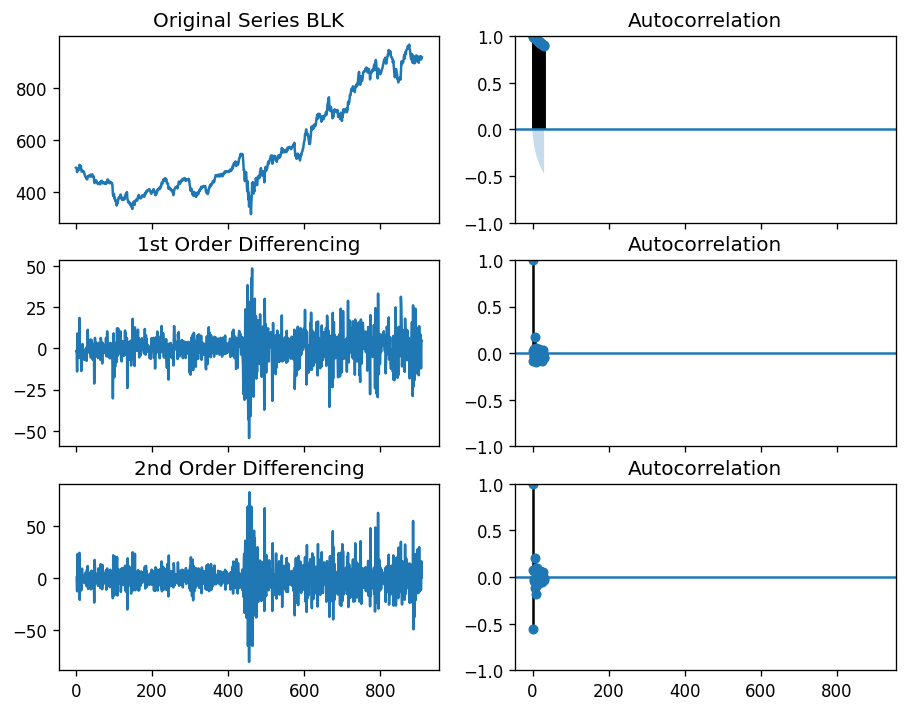



     ***  Results from differencing  ***   
Differences by ADF: 1
Differences by KPSS: 1
Differences by PP: 1


In [36]:
differencing_tests(data_blk_trim, 'BLK', 'Adj Close')

For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced.

#### Rules for $d$ term

- **Rule 1**: If the series has positive autocorrelations out to a high number of lags (say, 10 or more), then it probably needs a higher order of differencing.


- **Rule 2**: If the lag-1 autocorrelation is zero or negative, or the autocorrelations are all small and patternless, then the series does not need a higher order of differencing. If the lag-1 autocorrelation is -0.5 or more negative, the series may be overdifferenced.  BEWARE OF OVERDIFFERENCING.


- **Rule 3**: The optimal order of differencing is often the order of differencing at which the standard deviation is lowest. (Not always, though. Slightly too much or slightly too little differencing can also be corrected with AR or MA terms. See rules 6 and 7.)


- **Rule 4**: A model with no orders of differencing assumes that the original series is stationary (among other things, mean-reverting). A model with one order of differencing assumes that the original series has a constant average trend (e.g. a random walk or SES-type model, with or without growth). A model with two orders of total differencing assumes that the original series has a time-varying trend (e.g. a random trend or LES-type model).


- **Rule 5**: A model with no orders of differencing normally includes a constant term (which allows for a non-zero mean value). A model with two orders of total differencing normally does not include a constant term. In a model with one order of total differencing, a constant term should be included if the series has a non-zero average trend.


### Find order of AR term $p$

The next step is to identify if the model needs any AR terms. You can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

But what is PACF?

Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. That way, you will know if that lag is needed in the AR term or not.

#### PACF Term

Partial autocorrelation of lag (k) of a series is the coefficient of that lag in the autoregression equation of $Y$

$$Y_{t} = \alpha_{0}+\alpha_{1}Y_{t-1}+\alpha_{2}Y_{t-2}+...$$

uppose, if $Y_{t}$ is the current series and $Y_{t-1}$ is the lag 1 of $Y$, then the partial autocorrelation of lag 3 ($Y_{t-3}$) is the coefficient $\alpha_{3}$ of $Y_{t-3}$ in the above equation.

#### How to find the number of AR terms?

Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. So, we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.

In [37]:
## Remove index from dataframe
series1 = data_blk_trim.reset_index(drop=True)

  ## Declare as dataframe
seriesBLK = pd.DataFrame(series1['Adj Close'])

In [38]:
def pacf_viz(dataframe, ticker, columnName):
  '''
  DESC.: Function that takes a dataframe and outputs the PACF
  INPUT: dataframe (pandas, taken from yfinance)
  INPUT: ticker (str)
  INPUT: columnName (str)
  '''
  ## Remove index from dataframe
  series1 = dataframe.reset_index(drop=True)

  ## Declare as dataframe
  series = pd.DataFrame(series1[columnName])

  ## Set dimensions for plots
  plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

  ## Forat for plots
  fig, axes = plt.subplots(1, 2) #sharex=True)

  ## Declare first (left) plot
  axes[0].plot(series.diff()); axes[0].set_title('1st Differencing ' + ticker)

  ## X limits for 1st plot
  axes[0].set(xlim=(0, len(series)))

  ## X and Y limits for 2nd plot
  axes[1].set(xlim=(0,20))
  axes[1].set(ylim=(0,1))

  ## Declare 2nd (right) plot
  plot_pacf(series.diff().dropna(), ax=axes[1], lags = 30)

  plt.show()


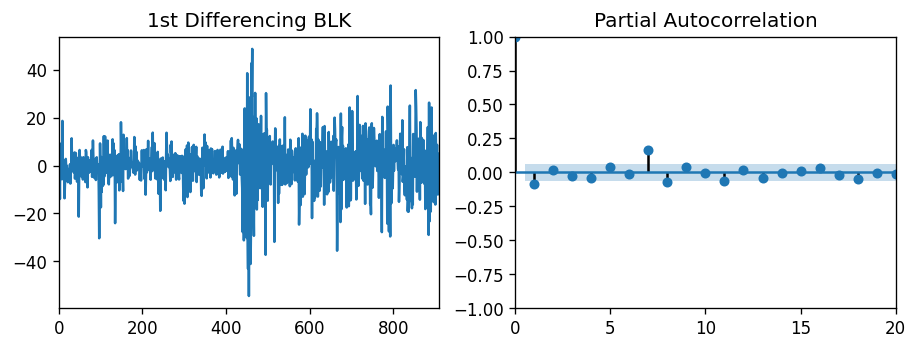

In [39]:
pacf_viz(data_blk_trim, 'BLK', 'Adj Close')

### Find order of MA Term $q$


An MA term is technically, the error of the lagged forecast.

The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.

In [40]:
def acf_viz(dataframe, ticker, columnName):
  '''
  DESC.: Function that takes a dataframe and outputs ACF 
  INPUT: dataframe (pandas, taken from yfinance)
  INPUT: ticker (str)
  INPUT: columnName (str)
  '''
  ## Remove index from dataframe
  series1 = dataframe.reset_index(drop=True)

  ## Declare as dataframe
  series = pd.DataFrame(series1[columnName])

  ## Diensions for plots
  plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

  ## Format for plots
  fig, axes = plt.subplots(1, 2) #sharex=True)

  ## Declare 1st (left) plot
  axes[0].plot(seriesBLK.diff()); axes[0].set_title('1st Differencing '+ticker)

  ## Limit in X for 2nd plot
  axes[1].set(xlim=(0,20))

  ## Limit in Y for 2nd Plot
  axes[1].set(ylim=(0,0.5))

  ## Declare 2nd (right) plot
  plot_acf(seriesBLK.diff().dropna(), ax=axes[1])

  plt.show()

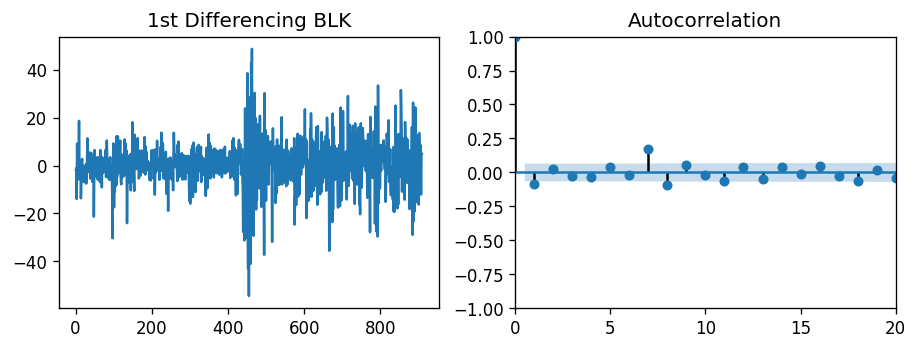

In [41]:
acf_viz(data_blk_trim, 'BLK', 'Adj Close')

### How to handle an under/over diferenced Time Series?

It may so happen that your series is slightly under differenced, that differencing it one more time makes it slightly over-differenced.

How to handle this case?

If your series is slightly under differenced, adding one or more additional AR terms usually makes it up. Likewise, if it is slightly over-differenced, try adding an additional MA term.


#### Rules for AR and MA terms

- **Rule 6**: If the partial autocorrelation function (PACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., if the series appears slightly "underdifferenced"--then consider adding one or more AR terms to the model. The lag beyond which the PACF cuts off is the indicated number of AR terms.


- **Rule 7**: If the autocorrelation function (ACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag beyond which the ACF cuts off is the indicated number of MA terms.


- **Rule 8**: It is possible for an AR term and an MA term to cancel each other's effects, so if a mixed AR-MA model seems to fit the data, also try a model with one fewer AR term and one fewer MA term--particularly if the parameter estimates in the original model require more than 10 iterations to converge. **BEWARE OF USING MULTIPLE AR TERMS AND MULTIPLE MA TERMS IN THE SAME MODEL**.


- **Rule 9**: If there is a unit root in the AR part of the model--i.e., if the sum of the AR coefficients is almost exactly 1--you should reduce the number of AR terms by one and increase the order of differencing by one.


- **Rule 10**: If there is a unit root in the MA part of the model--i.e., if the sum of the MA coefficients is almost exactly 1--you should reduce the number of MA terms by one and reduce the order of differencing by one.


- **Rule 11**: If the long-term forecasts* appear erratic or unstable, there may be a unit root in the AR or MA coefficients.

### Rules for Seasonal part of the model

- **Rule 12**: If the series has a strong and consistent seasonal pattern, then you must use an order of seasonal differencing (otherwise the model assumes that the seasonal pattern will fade away over time). However, never use more than one order of seasonal differencing or more than 2 orders of total differencing (seasonal+nonseasonal).


- **Rule 13**: If the autocorrelation of the appropriately differenced series is positive at lag s, where s is the number of periods in a season, then consider adding an SAR term to the model. If the autocorrelation of the differenced series is negative at lag s, consider adding an SMA term to the model. The latter situation is likely to occur if a seasonal difference has been used, which should be done if the data has a stable and logical seasonal pattern. The former is likely to occur if a seasonal difference has not been used, which would only be appropriate if the seasonal pattern is not stable over time. You should try to avoid using more than one or two seasonal parameters (SAR+SMA) in the same model, as this is likely to lead to overfitting of the data and/or problems in estimation.

### Building an ARIMA Model


In [42]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(seriesBLK, order=(1,0,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  910
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -3398.071
Date:                Fri, 31 Dec 2021   AIC                           6806.142
Time:                        19:05:54   BIC                           6830.210
Sample:                             0   HQIC                          6815.331
                                - 910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        570.7889    334.281      1.708      0.088     -84.390    1225.967
ar.L1          0.9991      0.001    735.961      0.000       0.996       1.002
ma.L1         -0.0796      0.019     -4.141      0.0

In [43]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(seriesBLK, order=(1,0,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  910
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -3398.353
Date:                Fri, 31 Dec 2021   AIC                           6804.705
Time:                        19:05:56   BIC                           6823.959
Sample:                             0   HQIC                          6812.057
                                - 910                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        570.8194    344.351      1.658      0.097    -104.096    1245.735
ar.L1          0.9991      0.001    763.578      0.000       0.997       1.002
ma.L1         -0.0792      0.019     -4.089      0.0

### Check for Residuals

Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).

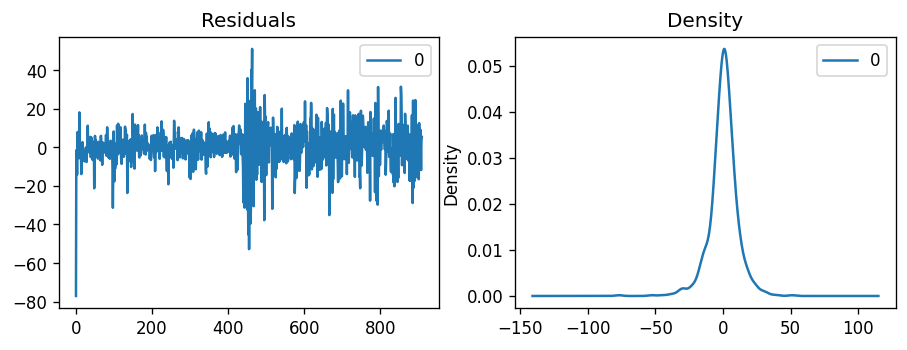

In [44]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residual errors seem fine with near zero mean and uniform variance. Let’s plot the actuals against the fitted values using plot_predict().

In [45]:
import statsmodels

In [46]:
statsmodels.__version__

'0.13.1'

In [47]:
!pip install statsmodels --upgrade

#### Comparing Prediction vs. Original Series

In [48]:
model_fit_predict = model_fit.predict(dynamic=False)
df_model_fit_predict = pd.DataFrame(model_fit_predict)

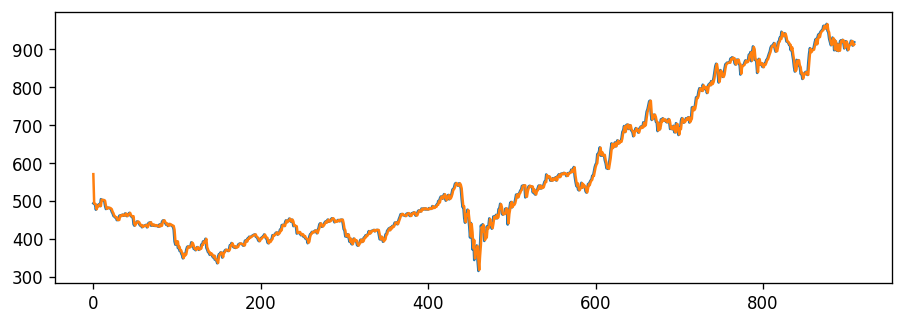

In [49]:
plt.plot(seriesBLK)
plt.plot(df_model_fit_predict)

### Out-of-Time Cross Validation

In Out-of-Time cross-validation, you take few steps back in time and forecast into the future to as many steps you took back. Then you compare the forecast against the actuals.

To do out-of-time cross-validation, you need to create the training and testing dataset by splitting the time series into 2 contiguous parts in approximately 75:25 ratio or a reasonable proportion based on time frequency of series.

In [50]:
len(seriesBLK)

910

In [51]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = seriesBLK[:len(seriesBLK)-85]
test = seriesBLK[len(seriesBLK)-85:]

In [52]:
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit()  

In [53]:
fitted.forecast(steps = 85, alpha=0.05)

825    934.948026
826    934.921237
827    934.931806
828    934.927636
829    934.929282
          ...    
905    934.928816
906    934.928816
907    934.928816
908    934.928816
909    934.928816
Name: predicted_mean, Length: 85, dtype: float64

In [54]:
forecast1 = fitted.get_forecast(steps = 85, alpha=0.05)

In [55]:
def ARIMA_Cross_Validation(dataframe, ticker, forecastSteps, p, d, q, alphaValue):
  '''
  DESC.: Function that takes a dataframe and its corresponding parameters for ARIMA model
          and outputs the plot with the forecast.
  INPUT: dataframe (pandas, taken from yfinance)
  INPUT: ticker (str)
  INPUT: forecastSteps (int, steps to be taken into account for forecasting)
  INPUT: p (int, AR term)
  INPUT: d (int, Differencing term)
  INPUT: q (int, MA term)
  INPUT: alphaValue (float, significance level)
  OUTPUT: Summary and Plot with cross validation
  '''
  ## Create training and test sets
  train = dataframe[:len(dataframe)-forecastSteps]
  test = dataframe[len(dataframe)-forecastSteps:]

  ## ARIMA model
  model = ARIMA(train, order=(p, d, q))
  fitted = model.fit()

  ## Print Summary 
  print(fitted.summary())

  ## Get forecast dataframe
  forecast = fitted.get_forecast(steps = forecastSteps, alpha = alphaValue)
  fc_forecast = forecast.summary_frame()

  ## Get needed columns from the forecast dataframe
  fc_series = pd.Series(fc_forecast['mean'], index = test.index)
  lower_series = pd.Series(fc_forecast['mean_ci_lower'], index = test.index)
  upper_series = pd.Series(fc_forecast['mean_ci_upper'], index = test.index)

  ## Plot forecast vs. actuals
  plt.figure(figsize=(12,5), dpi=100)
  plt.plot(train, label='training')
  plt.plot(test, label='actual')
  plt.plot(fc_series, label='forecast')
  plt.fill_between(lower_series.index, lower_series, upper_series, 
                   color='k', alpha=.15)
  plt.title('Forecast vs Actuals ' + ticker)
  plt.legend(loc='upper left', fontsize=8)
  plt.show()

  return test, fc_series

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  825
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -3055.176
Date:                Fri, 31 Dec 2021   AIC                           6114.353
Time:                        19:06:07   BIC                           6123.781
Sample:                             0   HQIC                          6117.970
                                - 825                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0914      0.019     -4.758      0.000      -0.129      -0.054
sigma2        97.2787      2.790     34.861      0.000      91.809     102.748
Ljung-Box (L1) (Q):                   0.00   Jarque-

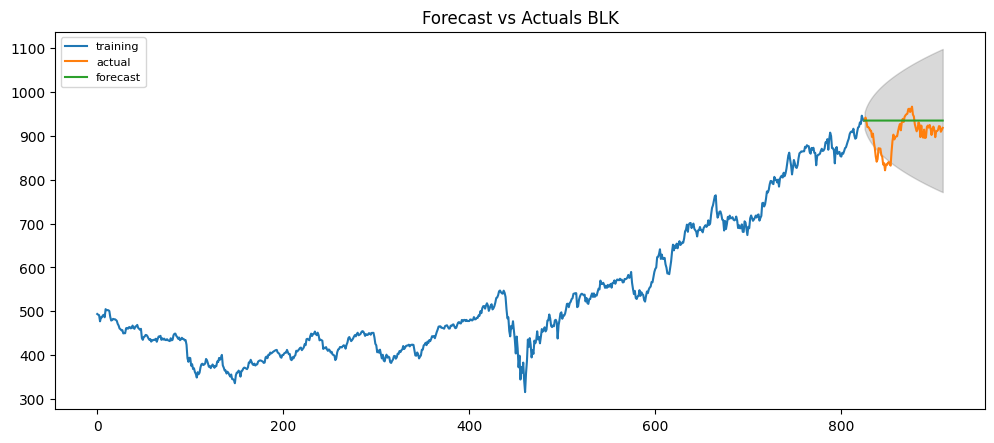

In [56]:
test, fc_series = ARIMA_Cross_Validation(seriesBLK, 'BLK', 85, 1, 1, 0, 0.05)

From the chart, the ARIMA(1,1,1) model seems to give a directionally correct forecast. And the actual observed values lie within the 95% confidence band. That seems fine.

But each of the predicted forecasts is the average of the actuals. That means, by adding a small constant to our forecast, the accuracy will certainly improve. So, there is definitely scope for improvement.

So, what I am going to do is to increase the order of differencing to two, that is set d=2 and iteratively increase p to up to 5 and then q up to 5 to see which model gives least AIC and also look for a chart that gives closer actuals and forecasts.

While doing this,  **keep an eye on the P values of the AR and MA terms in the model summary. They should be as close to zero, ideally, less than 0.05**.

For the case of BLK, upt to December 27, 2021, the best model according to *p-values* for AR and MA terms and the AIC score is ARIMA ($p = 1, d = 1, q = 0$).

### Accuracy Metrics for Time Series Forecast

The commonly used accuracy metrics to judge forecasts are:

1. Mean Absolute Percentage Error (MAPE)


2. Mean Error (ME)


3. Mean Absolute Error (MAE)


4. Mean Percentage Error (MPE)


5. Root Mean Squared Error (RMSE)


6. Lag 1 Autocorrelation of Error (ACF1)


7. Correlation between the Actual and the Forecast (corr)


8. Min-Max Error (minmax)

Typically, if you are comparing forecasts of two different series, the MAPE, Correlation and Min-Max Error can be used.

Why not use the other metrics?

Because only the above three are percentage errors that vary between 0 and 1. That way, you can judge how good is the forecast irrespective of the scale of the series.

The other error metrics are quantities. That implies, an RMSE of 100 for a series whose mean is in 1000’s is better than an RMSE of 5 for series in 10’s. So, you can’t really use them to compare the forecasts of two different scaled time series.

In [57]:
from statsmodels.tsa.stattools import acf

# Accuracy metrics
def forecast_accuracy_metrics(forecast, actual, columnName):
  '''
  DESC.: Function that takes dataframes for the forecast and the actual values
          and calculates different accuracy metrics
  INPUT: forecast (dataframe, from ARIMA_Cross_Validation)
  INPUT: actual (dataframe, from ARIMA_CROSS_Validation)
  INPUT: columnName (str, either Adj Close or Log Returns)
  OUTPUT: Accuracy metrics
  '''
  forecast = forecast.to_numpy()
  actual = actual[columnName].to_numpy()
  mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
  me = np.mean(forecast - actual)             # ME
  mae = np.mean(np.abs(forecast - actual))    # MAE
  mpe = np.mean((forecast - actual)/actual)   # MPE
  rmse = np.mean((forecast - actual)**2)**.5  # RMSE
  corr = np.corrcoef(forecast, actual)[0,1]   # corr
  mins = np.amin(np.hstack([forecast[:,None], 
                            actual[:,None]]), axis=1)
  maxs = np.amax(np.hstack([forecast[:,None], 
                            actual[:,None]]), axis=1)
  minmax = 1 - np.mean(mins/maxs)             # minmax
  acf1 = acf(forecast-actual)[1]                      # ACF1
  return({'mape':mape, 'me':me, 'mae': mae, 
          'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
          'corr':corr, 'minmax':minmax})



In [58]:
forecast_accuracy_metrics(fc_series, test, 'Adj Close')

{'acf1': 0.9362794276197235,
 'corr': 0.08505491786664475,
 'mae': 35.92579678504228,
 'mape': 0.04105878507846982,
 'me': 30.885132664710426,
 'minmax': 0.03835332188302176,
 'mpe': 0.03578646573137874,
 'rmse': 47.02295818787437}

Our MAPE is of 3.7%, which means that our model roughly predicts the next 85 values with an accuracy of 96.3%

### Auto ARIMA Forecast in Python

Like R’s popular *auto.arima()* function, the **pmdarima package** provides *auto_arima()* with similar functionality.

*auto_arima()* uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the **least AIC**

In [59]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(seriesBLK, start_p=1, start_q=1,
                      test='adf',       ### use adftest to find optimal 'd'
                      max_p=7, max_q=7, ### maximum p and q
                      m=1,              ### frequency of series
                      d=None,           ### let model determine 'd'
                      seasonal=False,   ### No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6788.323, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6791.413, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6786.733, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6786.993, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6791.349, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6788.407, Time=0.54 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6790.316, Time=1.83 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=6787.025, Time=0.13 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 3.446 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  910
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -3390.367
Date:                Fri, 31 Dec 2021   AIC                           6786.733
Time:                        19:06:1

### How to interpret Residual Plots in ARIMA Model

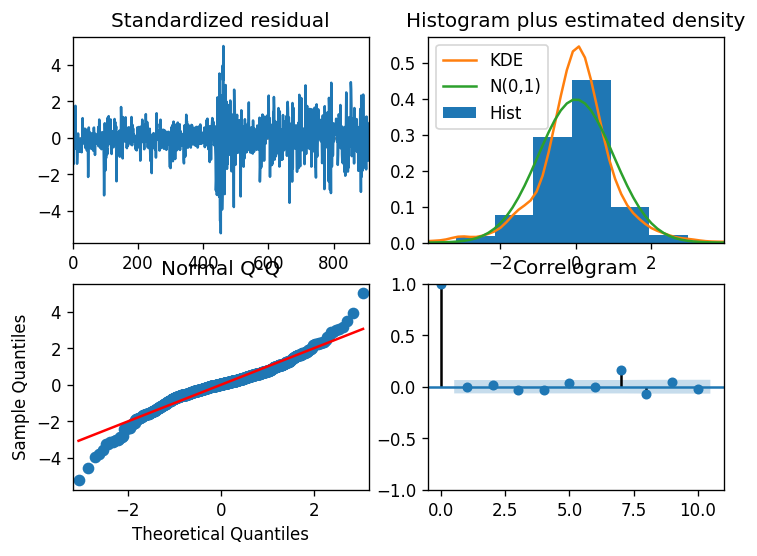

In [60]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

- **Top left**: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.


- **Top Right**: The density plot suggest normal distribution with mean zero.


- **Bottom left**: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.


- **Bottom Right**: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

### Auto ARIMA Forecast

In [61]:
def Auto_ARIMA_Forecast(dataframe, model, periods, ticker):
  '''
  DESC. Function that takes a dataframe and the model built in order to
        output the forecast
  INPUT: dataframe (pandas, from yfinance)
  INPUT: model (pmdarima auto_arima() object)
  INPUT: periods (int, desired number of periods to predict)
  INPUT: ticker (str)
  OUTPUT: 
  '''
  ## Run prediction from model
  fc, confint = model.predict(n_periods = periods, return_conf_int=True)

  ## Declare index of forecast
  index_of_fc = np.arange(len(dataframe), len(dataframe) + periods)

  ## make series for plotting purpose
  fc_series = pd.Series(fc, index=index_of_fc)
  lower_series = pd.Series(confint[:, 0], index=index_of_fc)
  upper_series = pd.Series(confint[:, 1], index=index_of_fc)

  # Plot
  plt.plot(dataframe)
  plt.plot(fc_series, color='darkgreen')
  plt.fill_between(lower_series.index, 
                   lower_series, 
                   upper_series, 
                   color='k', alpha=.15)

  plt.title("Final Forecast of " + ticker)
  plt.show()

  return fc_series

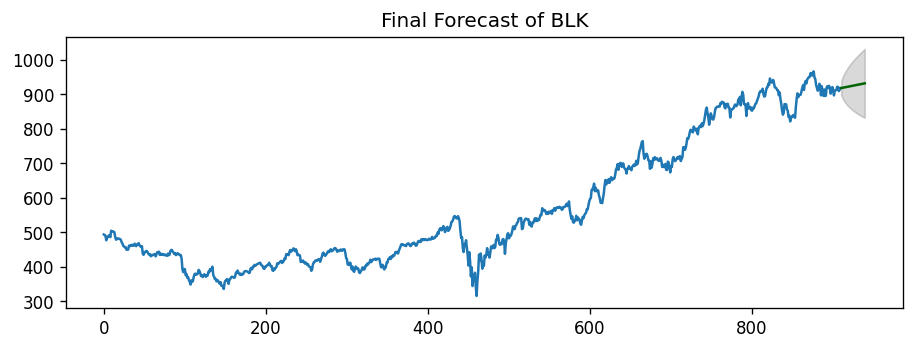

In [62]:
fc_BLK = Auto_ARIMA_Forecast(seriesBLK, model, 30, 'BLK')

## SARIMA Model in Python

The problem with plain ARIMA model is it does not support seasonality.

If your time series has defined seasonality, then, go for SARIMA which uses seasonal differencing.

Seasonal differencing is similar to regular differencing, but, instead of subtracting consecutive terms, you subtract the value from previous season.

So, the model will be represented as SARIMA($p,d,q$)x($P,D,Q$), where, $P, D$ and $Q$ are SAR, order of seasonal differencing and SMA terms respectively and 'x' is the frequency of the time series.

If your model has well defined seasonal patterns, then enforce $D=1$ for a given frequency ‘x’.

Here’s some practical advice on building SARIMA model:

As a general rule, set the model parameters such that $D$ never exceeds one. And the total differencing ‘$d + D$’ never exceeds $2$. Try to keep only either SAR or SMA terms if your model has seasonal components.

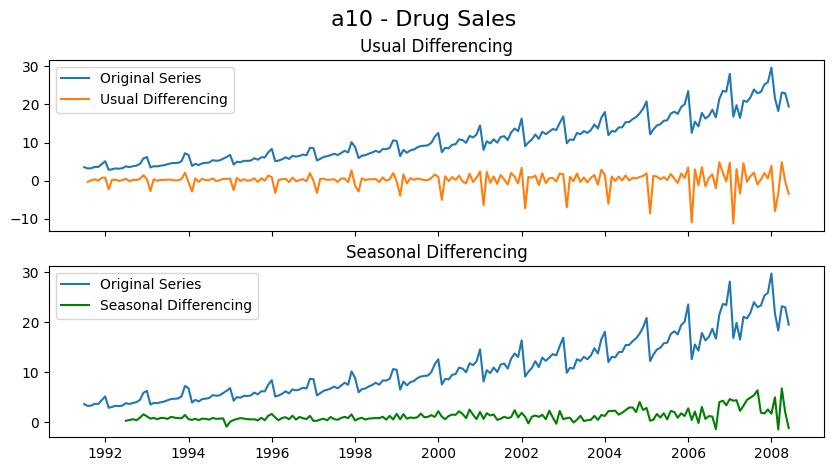

In [63]:
# Import
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(data[:], label='Original Series')
axes[1].plot(data[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('a10 - Drug Sales', fontsize=16)
plt.show()

As you can clearly see, the seasonal spikes is intact after applying usual differencing (lag 1). Whereas, it is rectified after seasonal differencing.

Let’s build the SARIMA model using pmdarima‘s *auto_arima()*. To do that, you need to set seasonal=True, set the frequency m=12 for month wise series and enforce D=1.

In [64]:
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=534.818, Time=3.95 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=624.061, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=596.068, Time=1.14 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=611.475, Time=0.81 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=757.274, Time=0.07 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=559.407, Time=0.78 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=5.48 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=536.817, Time=10.73 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=543.106, Time=3.24 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=537.559, Time=10.11 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=594.467, Time=0.73 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=529.829, Time=2.62 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=555.198, Time=0.77 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=4.99 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(1, 0, 2)x(1, 1, 2, 12)   Log Likelihood                -254.030
Date:                            Fri, 31 Dec 2021   AIC                            524.060
Time:                                    19:08:49   BIC                            550.120
Sample:                                         0   HQIC                           534.615
                                            - 204                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0052      0.009      0.564      0.573      -0.013       0.023
ar.L1          0.9757      0.018     52.828      0.000       0.939       1.012
ma.L1         -0.8963      0.056    -15.948      0.000      -1.006      -0.786
ma.L2          0.2059      0.058      3.578      0.000       0.093       0.319
ar.S.L12       0.8440      0.174      4.852      0.000       0.503       1.185
ma.S.L12      -1.5566      0.192     -8.097      0.000      -1.933      -1.180
ma.S.L24       0.7293      0.113      6.437      0.000       0.507       0.951
sigma2         0.7549      0.063     12.065      0.000       0.632       0.878
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):               142.52
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):              14.49   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The model has estimated the AIC and the P values of the coefficients look significant. Let’s look at the residual diagnostics plot.

The best model SARIMAX(1, 0, 2)x(1, 1, 2, 12) has an AIC of 524 and the P Values are significant.

Let’s forecast for the next 24 months.

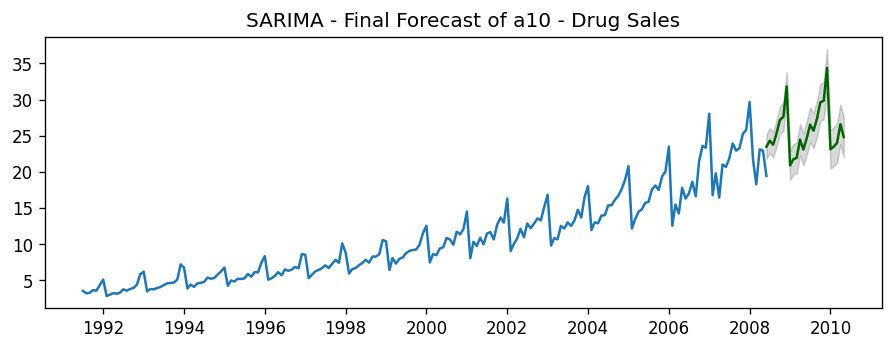

In [65]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()

### SARIMAX Model with Exogenous Variable

The SARIMA model we built is good. I would stop here typically.

But for the sake of completeness, let’s try and force an external predictor, also called, ‘exogenous variable’ into the model. This model is called the SARIMAX model.

The only requirement to use an exogenous variable is you need to know the value of the variable during the forecast period as well.

For the sake of demonstration, I am going to use the seasonal index from the classical seasonal decomposition on the latest 36 months of data.

Why the seasonal index? Isn’t SARIMA already modeling the seasonality, you ask?

You are correct.

But also, I want to see how the model looks if we force the recent seasonality pattern into the training and forecast.

Secondly, this is a good variable for demo purpose. So you can use this as a template and plug in any of your variables into the code. The seasonal index is a good exogenous variable because it repeats every frequency cycle, 12 months in this case.

So, you will always know what values the seasonal index will hold for the future forecasts.

In [66]:
# Import Data
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

Let’s compute the seasonal index so that it can be forced as a (exogenous) predictor to the SARIMAX model.

In [67]:
# Compute Seasonal Index
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# multiplicative seasonal component
result_mul = seasonal_decompose(data['value'][-36:],   # 3 years
                                model='multiplicative', 
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# merge with the base data
data['month'] = data.index.month
df = pd.merge(data, seasonal_index, how='left', on='month')
df.columns = ['value', 'month', 'seasonal_index']
df.index = data.index  # reassign the index.

The exogenous variable (seasonal index) is ready. Let’s build the SARIMAX model.

In [68]:
import pmdarima as pm

# SARIMAX Model
sxmodel = pm.auto_arima(df[['value']], exogenous=df[['seasonal_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=536.818, Time=2.00 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=626.061, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=598.068, Time=0.64 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=613.475, Time=0.46 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=759.274, Time=0.14 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=561.407, Time=0.42 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.75 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=538.817, Time=4.19 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=545.106, Time=1.58 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=539.549, Time=6.04 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=596.467, Time=0.47 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=531.829, Time=1.54 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=557.198, Time=0.47 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=3.09 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  204
Model:             SARIMAX(2, 0, 1)x(1, 1, [1, 2], 12)   Log Likelihood                -254.176
Date:                                 Fri, 31 Dec 2021   AIC                            524.352
Time:                                         19:11:33   BIC                            550.412
Sample:                                     07-01-1991   HQIC                           534.907
                                          - 06-01-2008                                         
Covariance Type:                                   opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
seasonal_index  -8.82e-06   2.76e+04   -3.2e-10      1.000    -5.4e+04     5.4e+04
ar.L1              0.6750      0.069      9.744      0.000       0.539       0.811
ar.L2              0.3149      0.064      4.923      0.000       0.190       0.440
ma.L1             -0.6390      0.063    -10.124      0.000      -0.763      -0.515
ar.S.L12           0.8484      0.152      5.572      0.000       0.550       1.147
ma.S.L12          -1.5857      0.174     -9.122      0.000      -1.926      -1.245
ma.S.L24           0.7618      0.110      6.946      0.000       0.547       0.977
sigma2             0.7455      0.068     10.924      0.000       0.612       0.879
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               197.88
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):              15.44   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

So, we have the model with the exogenous term. But the coefficient is very small for x1, so the contribution from that variable will be negligible. Let’s forecast it anyway.

We have effectively forced the latest seasonal effect of the latest 3 years into the model instead of the entire history.

Alright let’s forecast into the next 24 months. For this, you need the value of the seasonal index for the next 24 months.

In [69]:
seasonal_index

,seasonal,month
date,,
2007-07-01,0.970490,7
2007-08-01,1.050900,8
2007-09-01,0.998881,9
2007-10-01,1.059657,10
2007-11-01,1.146141,11
2007-12-01,1.150750,12
2008-01-01,1.316913,1
2008-02-01,0.803279,2
2008-03-01,0.850667,3


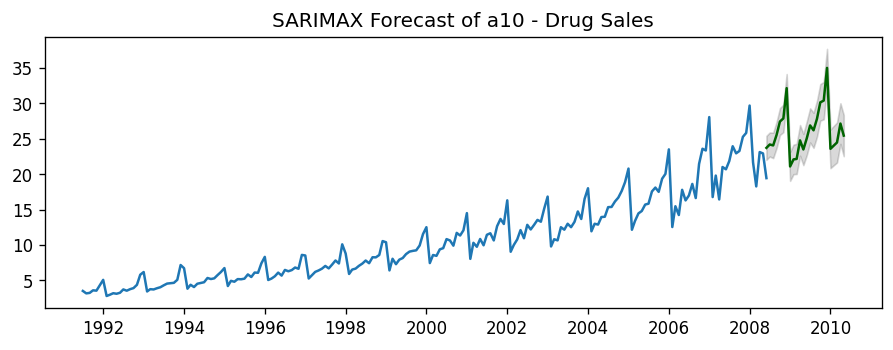

In [70]:
# Forecast
n_periods = 24
fitted, confint = sxmodel.predict(n_periods=n_periods, 
                                  exogenous=np.tile(seasonal_index.seasonal, 2).reshape(-1,1), 
                                  return_conf_int=True)

index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data['value'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMAX Forecast of a10 - Drug Sales")
plt.show()